<h1>using tutorial <a href="https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/">here</a></h1><br><br>
this notebook comprises the 'Explore Latent Space' section about halfway down. italicized section cell heads are ripped directly from there.

<em>The first step is to load the saved model and confirm that it can generate plausible faces.

    The model can be loaded using the <b>load_model()</b> function in the Keras API. We can then generate a number of random points in the latent space and use them as input to the loaded model to generate new faces. The faces can then be plotted.</em>

In [40]:
#to start we will load the generator model and begin generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import arccos
from numpy import clip
from numpy import dot
from numpy import sin
from numpy import linspace
from numpy.linalg import norm
from keras.models import load_model
from matplotlib import pyplot

In [2]:
#function to generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    #generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    #reshape into the shape of the latent space for input
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [31]:
#function to create and show a plot of generated images
def plot_generated(examples, n):
    #plot images
    for i in range(n):
        #define subplot
        pyplot.subplot(1, n, 1+i)
        #turn off axes
        pyplot.axis('off')
        #plot raw pixel data
        pyplot.imshow(examples[i, :, :])
    pyplot.show()

In [4]:
#load model
model = load_model('generator_model_189.h5')

C:\Users\jjeff\Anaconda3\envs\neuGAN\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
#generate points
latent_points = generate_latent_points(100, 25)

In [7]:
#generate_images
X = model.predict(latent_points)
#normalize from [-1,1] to [0,1]
X = (X + 1) / 2.0

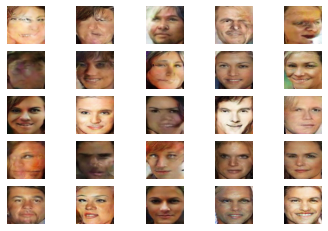

In [8]:
#plot the result
plot_generated(X,5)

<h3>next, we will make a LINEAR INTERPOLATION between two points in the latent space!</h3><br>
<em><p>The simplest interpolation we can use is a linear or uniform interpolation between two points in the latent space. We can achieve this using the <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html">linspace() NumPy function</a> to calculate ratios of the contribution from two points, then enumerate these ratios and construct a vector for each ratio.</p>
    <p>The <b>interpolate_points()</b> function below implements this and returns a series of linearly interpolated vectors between two points in latent space, including the first and last point.</p></em>

In [36]:
#uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    #interpolate ratios between the points
    ratios = linspace(0,1, num = n_steps)
    #linear interpolation vectors
    vectors = list()
    for ratio in ratios:
        #what the below does is return a 'mixed' number between the two
        #corresponding pairs of each (of 100)
        #dimensions of the latent points
        #you can see that they are 'fractional' mixes, i.e. 100-0, 80-20...
        v = slerp(ratio, p1, p2)
        vectors.append(v)
    return asarray(vectors)

In [24]:
p1 = latent_points[17]

In [25]:
p2 = generate_latent_points(100, 1)[0]
#NOTE THE ARRAY SELECTOR!!!!

In [41]:
#interpolate the actual two points you've chosen
interpolated = interpolate_points(p1, p2)

In [42]:
#generate images
X = model.predict(interpolated)
#again, normalize to [0,1]
X = (X + 1) / 2.0

In [46]:
len(X)
X.shape

(10, 80, 80, 3)

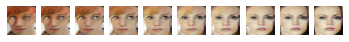

In [43]:
#plot the result
plot_generated(X, len(interpolated))

<em><p>[...] we have performed a linear interpolation which assumes that the latent space is uniformly distributed hypercube. Technically, our chosen latent space is a 100-dimension hypersphere or multimodal Gaussian distribution.</p>
<p>There is a mathematical function called the spherical linear interpolation function, or ‘<a href="https://en.wikipedia.org/wiki/Slerp">Slerp</a>,’ that should be used when interpolating this space to ensure the curving of the space is taken into account. For more details, I recommend reading the <a href="https://github.com/soumith/dcgan.torch/issues/14">Issue on Linear Interpolation in Soumith Chintala’s dcgan.torch project</a>. In that project, an implementation of the Slerp function for Python is provided that we can use as the basis for our own Slerp function, provided below:</p></em>

In [35]:
#latent space is hypersphere?! so we need spherical linear interp (SLERP)
def slerp(val, low, high):
    #no way in hell i can annotate this maths lol
    omega = arccos(clip(dot(low/norm(low), high/norm(high)), -1, 1))
    so = sin(omega)
    if so == 0:
        #l'hopital's rule/LERP
        #(this means if the sine of all that is 0, it's a straight line,
        #i.e. you do a linear interpolation anyway)
        return(1.0-val) * low + val * high
    return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high

In [55]:
frame_latents = list()

for n in range(len(latent_points) - 1):
    V = interpolate_points(latent_points[n], latent_points[n+1])
    for point in V:
        frame_latents.append(point)
V = interpolate_points(latent_points[-1], latent_points[1])
for point in V:
        frame_latents.append(point)

In [57]:
frames = asarray(frame_latents)

In [58]:
frames.shape

(250, 100)

In [60]:
for frame in frames:
    print(frame)

[ 0.12208336  0.33789785 -0.2969641   1.60486012  0.55754988 -0.35555712
  0.80828995  1.12909389  0.49534277 -0.49735196  0.37939873 -0.51679387
 -0.23323085 -1.55322167 -0.97911131 -1.85213305  1.05524353 -0.78253568
  0.63655763 -0.01555687 -0.85706279 -1.67535727 -0.18991978  0.37288604
 -0.0813404  -0.09443801  1.23314419  0.24352664  0.52443569  0.30367685
 -1.50371881  0.31212901  0.22151516 -1.25421051 -0.62143694 -0.94914162
 -0.58616455 -0.70597368 -0.53490438  0.04911087  0.71275469  1.04422683
 -0.63118418 -2.20466372  0.16979895 -0.69333755 -0.14919833  2.01629746
  0.08009123 -1.63527797  0.01729077  0.93851155  0.9580647  -0.61554159
 -1.03588336 -0.83624354 -0.56633431 -0.98755584 -0.53080516 -0.26186118
 -0.922596    1.8378839   1.11203621  1.54115945 -0.3652268   1.67516992
  0.12301665  0.50450468 -2.70724733  1.36116101  0.93540353 -0.88373869
 -0.69614448 -0.90814794  0.27532567 -0.43317465  0.84776977  0.02959278
 -1.49629621 -0.04029506  0.54161787 -1.34636144 -1